# Should you buy a home for a Full-Time Airbnb

## Importing Packages and Collecting Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium
import requests
from pandas.io.json import json_normalize
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
from IPython.display import display, HTML

In [2]:
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score

### Get the *Data* into the project. Link to Kaggle just in case because Why wouldn't you want to recreate this project and try to make a few bucks (or make much less than a few bucks depending on what we learn by the end of this notebook)

In [3]:
pd.set_option('display.max_columns', 20)
airbnb_file = 'AB_US_2020.csv'
linktofile = 'https://www.kaggle.com/kritikseth/us-airbnb-open-data'

In [4]:
# read the csv and print the dtypes to figure out what we can drop
df_airbnb = pd.read_csv(airbnb_file, low_memory=False)
df_airbnb['reviews_per_month'] = df_airbnb['reviews_per_month'].fillna(0)
print(df_airbnb.dtypes)

id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
city                               object
dtype: object


In [5]:
stopwords = list(STOPWORDS)
comment_words = []
for val in df_airbnb['name']:    # for loop iterate through dataframe series
    # typecast each val to string
    val = str(val)
    # split the value
    tokens = val.split()                   # tokens is a list of the words in the pd series
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
        comment_words.append(tokens[i])

#counts the totals for each word (number of times appeared)
comment_words_nostop = [x for x in comment_words if x not in stopwords]
comment_words_dict = Counter(comment_words_nostop)
comment_list = comment_words_dict.most_common(100)

wordlist = []
for item in comment_list:
    wordlist.append(item[0])

print(wordlist)

['private', 'room', 'bedroom', '-', 'home', '&', 'apartment', 'studio', 'cozy', '2', 'near', 'beach', '1', 'house', '|', 'downtown', 'modern', 'spacious', 'condo', 'beautiful', 'luxury', 'w/', 'apt', 'view', 'ocean', 'suite', 'park', 'heart', 'new', 'close', 'bed', 'bath', '1br', 'walk', '3', 'charming', 'east', 'great', '+', 'pool', 'large', 'sunny', 'location', 'views', 'loft', '2br', 'one', 'quiet', 'city', 'garden', 'central', 'cottage', 'hollywood', 'clean', 'bright', 'west', 'brooklyn', 'parking', 'austin', 'guest', 'br', 'hill', 'retreat', '4', 'village', 'san', 'resort', 'manhattan', 'min', 'place', 'steps', 'amazing', 'historic', 'floor', 'bathroom', 'la', 'minutes', 'queen', 'sleeps', '5', 'nyc', 'perfect', 'oasis', 'free', 'south', 'bungalow', 'stay', 'renovated', 'master', 'king', 'gorgeous', 'north', 'best', 'shared', 'family', 'williamsburg', 'lovely', 'two', 'entire', 'lake']


### Here we're gonna define a few functions that rely on the new wordlist to add word features

In [6]:
def getWordData(df):
    '''

    :param df: the dataframe you want to input
    :return: the new appended dataframe
    '''
    df_word = df[['name']]     # read in the dataframe column with text
    for word in wordlist:      # for each word in the wordlist we're going to check if the row has the word
        bool_list = []
        for value in df['name']:  # for each row we see if it contains the current word
            bool_list.append(int(word in str(value).lower())) #make it lowercase
        df_word[word] = bool_list    # new column is boolean of if name contains the word
    df_word.drop(['name'], inplace = True, axis = 1)
    return pd.concat([df, df_word], axis=1)


def CreateDFbyCity(df, city):
    df_city = df[df['city'] == city].drop(['city'], axis = 1)
    df_city = getWordData(df_city).drop(['name'], axis = 1)
    df_city.to_csv('Airbnb_Data_' + city + '.csv')
    return df_city

In [7]:
df_airbnb_drop = df_airbnb.drop(['id', 'host_id', 'host_name', 'neighbourhood_group', 'neighbourhood', 'last_review'], axis=1)  
# remove a whole lot of unnecessary info

dummy_dum = pd.get_dummies(df_airbnb_drop['room_type'])  # get all the dummy variables for room type
#  create another table with dummy values for room type

df_bnb_withdummy = pd.concat([df_airbnb_drop, dummy_dum], axis = 1, sort = False)    # concatenate the dummy variables
df_bnb_withdummy.drop(['room_type'], inplace = True, axis = 1)    # drop the room type column now that we have dummies
df_bnb_withdummy['logPrice'] = np.log10(df_bnb_withdummy['price']+1)               # create a new column with logprice
df_bnb_withdummy_words = getWordData(df_bnb_withdummy)                    # add all the numerical word data to the dataframe


<ipython-input-6-758792d0d63e>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_word[word] = bool_list    # new column is boolean of if name contains the word


In [8]:
city_list = list(df_airbnb['city'].unique())
print(city_list)

['Asheville', 'Austin', 'Boston', 'Broward County', 'Cambridge', 'Chicago', 'Clark County', 'Columbus', 'Denver', 'Hawaii', 'Jersey City', 'Los Angeles', 'Nashville', 'New Orleans', 'New York City', 'Oakland', 'Pacific Grove', 'Portland', 'Rhode Island', 'Salem', 'San Clara Country', 'San Diego', 'San Francisco', 'San Mateo County', 'Santa Cruz County', 'Seattle', 'Twin Cities MSA', 'Washington D.C.']


### The next block will create a list of data tables for each city

In [9]:
for city in city_list:
    CreateDFbyCity(df_bnb_withdummy, city)

<ipython-input-6-758792d0d63e>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_word[word] = bool_list    # new column is boolean of if name contains the word


In [10]:
df_bnb_withdummy.drop(['name', 'city'],inplace = True, axis =1 )         # drop the name and city columns
df_bnb_withdummy_words.drop(['name', 'city'],inplace = True, axis =1 )
df_locations = df_bnb_withdummy[['latitude','longitude']]               # get a location dataframe because real estate

In [11]:
# sanity check
df_bnb_withdummy_words

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,Entire home/apt,Hotel room,...,gorgeous,north,best,shared,family,williamsburg,lovely,two,entire,lake
0,35.651460,-82.627920,60,1,138,1.14,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,35.597790,-82.555400,470,1,114,1.03,11,288,1,0,...,0,0,0,0,0,0,0,0,0,0
2,35.606700,-82.555630,75,30,89,0.81,2,298,1,0,...,0,0,0,0,0,0,0,0,0,0
3,35.578640,-82.595780,90,1,267,2.39,5,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,35.614420,-82.541270,125,30,58,0.52,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226025,38.903880,-77.029730,104,1,0,0.00,2,99,1,0,...,0,0,0,0,0,0,0,0,0,0
226026,38.920820,-76.990980,151,2,0,0.00,1,300,1,0,...,0,0,0,0,0,0,0,0,0,0
226027,38.911170,-77.033540,240,2,0,0.00,1,173,1,0,...,0,0,0,0,0,0,0,0,0,0
226028,38.926630,-77.044360,60,21,0,0.00,5,362,1,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
df_bnb_withdummy

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,Entire home/apt,Hotel room,Private room,Shared room,logPrice
0,35.651460,-82.627920,60,1,138,1.14,1,0,0,0,1,0,1.785330
1,35.597790,-82.555400,470,1,114,1.03,11,288,1,0,0,0,2.673021
2,35.606700,-82.555630,75,30,89,0.81,2,298,1,0,0,0,1.880814
3,35.578640,-82.595780,90,1,267,2.39,5,0,1,0,0,0,1.959041
4,35.614420,-82.541270,125,30,58,0.52,1,0,0,0,1,0,2.100371
...,...,...,...,...,...,...,...,...,...,...,...,...,...
226025,38.903880,-77.029730,104,1,0,0.00,2,99,1,0,0,0,2.021189
226026,38.920820,-76.990980,151,2,0,0.00,1,300,1,0,0,0,2.181844
226027,38.911170,-77.033540,240,2,0,0.00,1,173,1,0,0,0,2.382017
226028,38.926630,-77.044360,60,21,0,0.00,5,362,1,0,0,0,1.785330


In [13]:
df_bnb_withdummy_words.to_csv('All_Numerical_With_Words.csv')
df_bnb_withdummy.to_csv('All_Numerical_Without_Words.csv')

## Visualizing the Data

### Histograms

Text(0.5, 0, 'Minimum Nights')

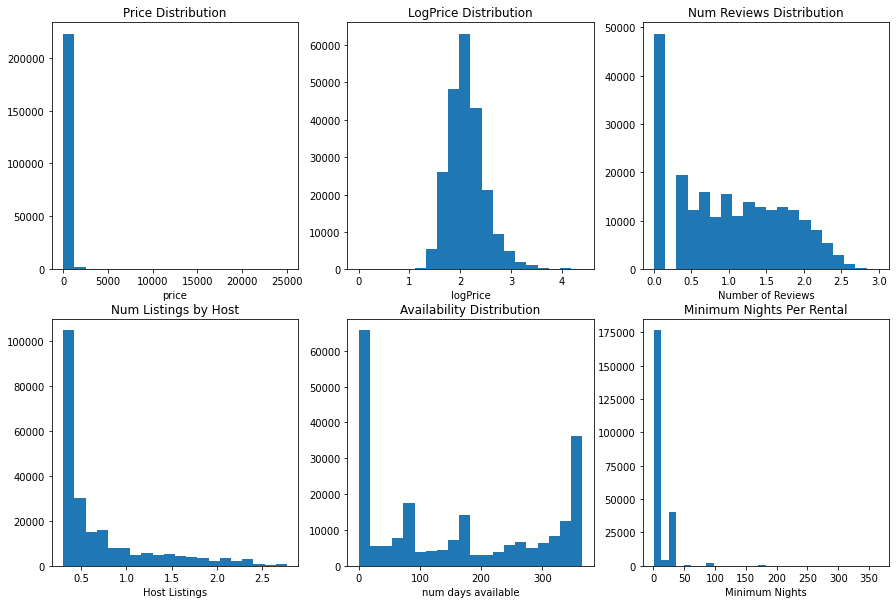

In [14]:
# price is heavily skewed due to outliers but logPrice is approximately normal
plt.figure(figsize = (15, 10))
plt.subplot(2, 3, 1)
plt.hist(df_airbnb['price'], bins = 20)
plt.title('Price Distribution')
plt.xlabel('price')

plt.subplot(2, 3, 2)
plt.hist(df_bnb_withdummy['logPrice'], bins = 20)
plt.title('LogPrice Distribution')
plt.xlabel('logPrice')
# note that log price is approximately normal which

plt.subplot(2, 3, 3)
plt.hist(np.log10(df_airbnb['number_of_reviews']+1), bins = 20)
plt.title('Num Reviews Distribution')
plt.xlabel('Number of Reviews')

plt.subplot(2, 3, 4)
plt.hist(np.log10(df_airbnb['calculated_host_listings_count']+1), bins = 20)
plt.title('Num Listings by Host')
plt.xlabel('Host Listings')

plt.subplot(2, 3, 5)
plt.hist(df_bnb_withdummy['availability_365'], bins = 20)
plt.title('Availability Distribution')
plt.xlabel('num days available')

plt.subplot(2, 3, 6)
plt.hist(df_bnb_withdummy[df_bnb_withdummy['minimum_nights'] < 365]['minimum_nights'], bins = 30)
plt.title('Minimum Nights Per Rental')
plt.xlabel('Minimum Nights')

In [15]:
# Can Figure that most hosts have one airbnb, 
# offer prices around 100-ish dollars, 
# offer availabilities on a per night, weekend, month, season, or year basis
# Usually only requires renting out for 1 night at a time excluding outliers longer than a year

#### ScatterPlots

Text(0, 0.5, 'Reviews per month')

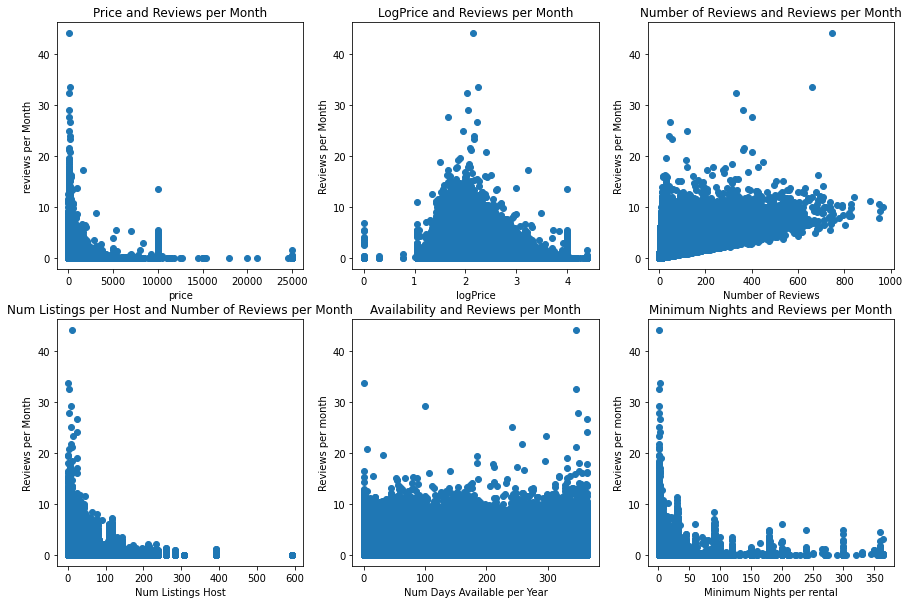

In [16]:
# price is heavily skewed due to outliers but logPrice is approximately normal
plt.figure(figsize = (15, 10))
plt.subplot(2, 3, 1)
plt.scatter(x = df_airbnb['price'], y = df_airbnb['reviews_per_month'])
plt.title('Price and Reviews per Month')
plt.xlabel('price')
plt.ylabel('reviews per Month')

plt.subplot(2, 3, 2)
plt.scatter(x = df_bnb_withdummy['logPrice'], y = df_bnb_withdummy['reviews_per_month'])
plt.title('LogPrice and Reviews per Month')
plt.xlabel('logPrice')
plt.ylabel('Reviews per Month')
# note that log price is approximately normal which

plt.subplot(2, 3, 3)
plt.scatter(x = df_bnb_withdummy['number_of_reviews'], y = df_bnb_withdummy['reviews_per_month'])
plt.title('Number of Reviews and Reviews per Month')
plt.xlabel('Number of Reviews')
plt.ylabel('Reviews per Month')
# note that log price is approximately normal which

plt.subplot(2, 3, 4)
plt.scatter(x = df_bnb_withdummy['calculated_host_listings_count'], y = df_bnb_withdummy['reviews_per_month'])
plt.title('Num Listings per Host and Number of Reviews per Month')
plt.xlabel('Num Listings Host')
plt.ylabel('Reviews per Month')
# note that log price is approximately normal which

plt.subplot(2, 3, 5)
plt.scatter(x = df_bnb_withdummy['availability_365'], y = df_bnb_withdummy['reviews_per_month'])
plt.title('Availability and Reviews per Month')
plt.xlabel('Num Days Available per Year')
plt.ylabel('Reviews per month')
# note that log price is approximately normal which

plt.subplot(2, 3, 6)
plt.scatter(x = df_bnb_withdummy[df_bnb_withdummy['minimum_nights'] < 365]['minimum_nights'],
            y = df_bnb_withdummy[df_bnb_withdummy['minimum_nights'] < 365]['reviews_per_month'])
plt.title('Minimum Nights and Reviews per Month')
plt.xlabel('Minimum Nights per rental')
plt.ylabel('Reviews per month')
# note that log price is approximately normal which

#### Word Cloud of most popular words

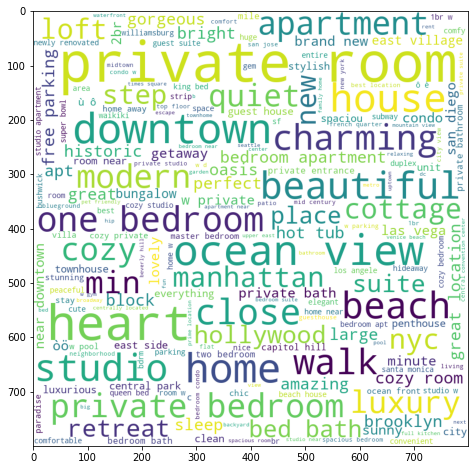

In [17]:
stopwords = set(STOPWORDS)
wordcloud = WordCloud(width = 800, height = 800, 
                      background_color ='white', 
                      stopwords = stopwords, 
                      min_font_size = 10).generate(' '.join(comment_words))
plt.figure(figsize = (8,8), facecolor = None)
plt.imshow(wordcloud)

## Clustering Cities into Neighborhood groups

##### We're gonna start with Asheville just to keep things simple-ish

In [18]:
df_Asheville = pd.read_csv('Airbnb_Data_Asheville.csv')

In [19]:
def clusterlabels(df, num):
    df_loc = df[['latitude','longitude']]
    kmeans_model = KMeans(n_clusters = num).fit(df_loc)
    df_copy = df
    df_copy['label k = ' + str(num)] = kmeans_model.labels_
    print(df_copy)
    return df_copy, list(kmeans_model.cluster_centers_.tolist())

In [20]:
df_temp3, centers3 = clusterlabels(df_Asheville, 3)
centers3

      Unnamed: 0  latitude  longitude  price  minimum_nights  \
0              0  35.65146  -82.62792     60               1   
1              1  35.59779  -82.55540    470               1   
2              2  35.60670  -82.55563     75              30   
3              3  35.57864  -82.59578     90               1   
4              4  35.61442  -82.54127    125              30   
...          ...       ...        ...    ...             ...   
2069        2069  35.46321  -82.57273    104               1   
2070        2070  35.56819  -82.63722     99               2   
2071        2071  35.59670  -82.51469    165               2   
2072        2072  35.47910  -82.51933    135               2   
2073        2073  35.55082  -82.46218    352               2   

      number_of_reviews  reviews_per_month  calculated_host_listings_count  \
0                   138               1.14                               1   
1                   114               1.03                              11 

[[35.58230386618364, -82.6058929210617],
 [35.597636270742356, -82.53417903056769],
 [35.47481400862069, -82.51903060344827]]

In [22]:
client_id = 
client_secret = 

In [23]:
url1_cafe = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&v=20180602&ll={},{}&query=cafe'.format(client_id, client_secret, str(centers3[0][0]), str(centers3[0][1]))
url2_cafe = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&v=20180602&ll={},{}&query=cafe'.format(client_id, client_secret, str(centers3[1][0]), str(centers3[1][1]))
url3_cafe = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&v=20180602&ll={},{}&query=cafe'.format(client_id, client_secret, str(centers3[2][0]), str(centers3[2][1]))
url1_food = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&v=20180602&ll={},{}&query=restaurant'.format(client_id, client_secret, str(centers3[0][0]), str(centers3[0][1]))
url2_food = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&v=20180602&ll={},{}&query=restaurant'.format(client_id, client_secret, str(centers3[1][0]), str(centers3[1][1]))
url3_food = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&v=20180602&ll={},{}&query=restaurant'.format(client_id, client_secret, str(centers3[2][0]), str(centers3[2][1]))
url1_fun = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&v=20180602&ll={},{}&query=bar'.format(client_id, client_secret, str(centers3[0][0]), str(centers3[0][1]))
url2_fun = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&v=20180602&ll={},{}&query=bar'.format(client_id, client_secret, str(centers3[1][0]), str(centers3[1][1]))
url3_fun = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&v=20180602&ll={},{}&query=bar'.format(client_id, client_secret, str(centers3[2][0]), str(centers3[2][1]))

In [24]:
results1 = requests.get(url1_cafe).json()
results2 = requests.get(url2_cafe).json()
results3 = requests.get(url3_cafe).json()
results1_food = requests.get(url1_food).json()
results2_food = requests.get(url2_food).json()
results3_food = requests.get(url3_food).json()
results1_fun = requests.get(url1_fun).json()
results2_fun = requests.get(url2_fun).json()
results3_fun = requests.get(url3_fun).json()

In [25]:
df1_cafe = json_normalize(results1['response']['venues'])
df2_cafe = json_normalize(results2['response']['venues'])
df3_cafe = json_normalize(results3['response']['venues'])
df1_food = json_normalize(results1_food['response']['venues'])
df2_food = json_normalize(results2_food['response']['venues'])
df3_food = json_normalize(results3_food['response']['venues'])
df1_fun = json_normalize(results1_fun['response']['venues'])
df2_fun = json_normalize(results2_fun['response']['venues'])
df3_fun = json_normalize(results3_fun['response']['venues'])

<ipython-input-25-ee576694d95c>:1: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  df1_cafe = json_normalize(results1['response']['venues'])
<ipython-input-25-ee576694d95c>:2: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  df2_cafe = json_normalize(results2['response']['venues'])
<ipython-input-25-ee576694d95c>:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  df3_cafe = json_normalize(results3['response']['venues'])
<ipython-input-25-ee576694d95c>:4: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  df1_food = json_normalize(results1_food['response']['venues'])
<ipython-input-25-ee576694d95c>:5: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  df2_food = json_normalize(results2_food['response']['venues'])
<ipython-input-25-ee576694d95c>:6: FutureWarn

Text(0.5, 1.0, 'Asheville Neighborhood Clusters and Number of Reviews')

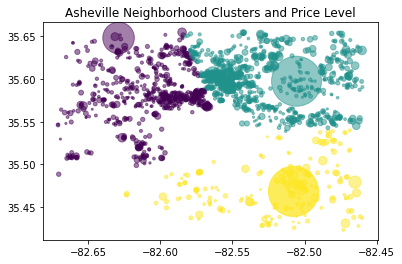

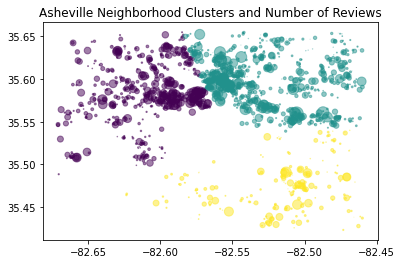

In [26]:
plt.scatter(y = df_temp3['latitude'], x = df_temp3['longitude'], c = df_temp3['label k = 3'], s = df_temp3['price']/10, alpha = 0.5)
plt.title('Asheville Neighborhood Clusters and Price Level')

plt.figure()
plt.scatter(y = df_temp3['latitude'], x = df_temp3['longitude'], c = df_temp3['label k = 3'], s = (df_temp3['reviews_per_month']**2), alpha = 0.5)
plt.title('Asheville Neighborhood Clusters and Number of Reviews')

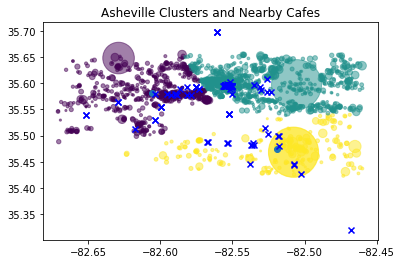

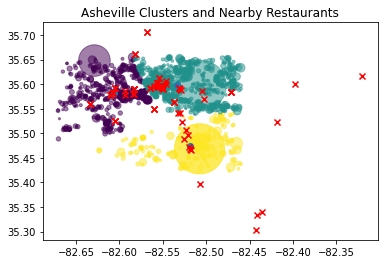

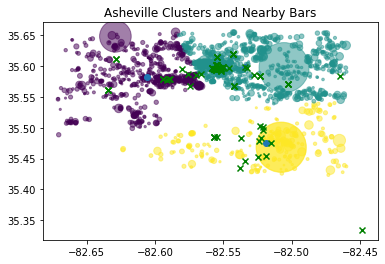

In [27]:
plt.figure()
plt.scatter(y = df_temp3['latitude'], x = df_temp3['longitude'], c = df_temp3['label k = 3'], s = df_temp3['price']/10, alpha = 0.5)
plt.scatter(y = [centers3[0][0], centers3[1][0], centers3[2][0]], x = [centers3[0][1], centers3[1][1], centers3[2][1]])
plt.scatter(y = df1_cafe['location.lat'], x = df1_cafe['location.lng'], marker='x', color = 'b')
plt.scatter(y = df2_cafe['location.lat'], x = df2_cafe['location.lng'], marker='x', color = 'b')
plt.scatter(y = df3_cafe['location.lat'], x = df3_cafe['location.lng'], marker='x', color = 'b')
plt.title('Asheville Clusters and Nearby Cafes')

plt.figure()
plt.scatter(y = df_temp3['latitude'], x = df_temp3['longitude'], c = df_temp3['label k = 3'], s = df_temp3['price']/10, alpha = 0.5)
plt.scatter(y = [centers3[0][0], centers3[1][0], centers3[2][0]], x = [centers3[0][1], centers3[1][1], centers3[2][1]])
plt.scatter(y = df1_food['location.lat'], x = df1_food['location.lng'], marker='x', color = 'r')
plt.scatter(y = df2_food['location.lat'], x = df2_food['location.lng'], marker='x', color = 'r')
plt.scatter(y = df3_food['location.lat'], x = df3_food['location.lng'], marker='x', color = 'r')
plt.title('Asheville Clusters and Nearby Restaurants')


plt.figure()
plt.scatter(y = df_temp3['latitude'], x = df_temp3['longitude'], c = df_temp3['label k = 3'], s = df_temp3['price']/10, alpha = 0.5)
plt.scatter(y = [centers3[0][0], centers3[1][0], centers3[2][0]], x = [centers3[0][1], centers3[1][1], centers3[2][1]])
plt.scatter(y = df1_fun['location.lat'], x = df1_fun['location.lng'], marker='x', color = 'g')
plt.scatter(y = df2_fun['location.lat'], x = df2_fun['location.lng'], marker='x', color = 'g')
plt.scatter(y = df3_fun['location.lat'], x = df3_fun['location.lng'], marker='x', color = 'g')
plt.title('Asheville Clusters and Nearby Bars')
plt.show()

In [28]:
def createmap(df, num):
    # Visualizing the plots for K = 5
    col_index = df.columns.get_loc('label k = ' + str(num))
    m = folium.Map(location=[df['latitude'].mean(),df['longitude'].mean()], zoom_start=12)
    for i in range(len(df.index)):
        if df.iloc[i, col_index] == 0:
            folium.Marker([df.iloc[i, 1], df.iloc[i, 2]], icon=folium.Icon(color='red')).add_to(m)
        if df.iloc[i, col_index] == 1:
            folium.Marker([df.iloc[i, 1], df.iloc[i, 2]], icon=folium.Icon(color='blue')).add_to(m)
        if df.iloc[i, col_index] == 2:
            folium.Marker([df.iloc[i, 1], df.iloc[i, 2]], icon=folium.Icon(color='green')).add_to(m)
        if df.iloc[i, col_index] == 3:
            folium.Marker([df.iloc[i, 1], df.iloc[i, 2]], icon=folium.Icon(color='orange')).add_to(m)
        if df.iloc[i, col_index] == 4:
            folium.Marker([df.iloc[i, 1], df.iloc[i, 2]], icon=folium.Icon(color='purple')).add_to(m)
    return m

createmap(df_Asheville, 3)

In [29]:
# get strictly location data from the loaded in json files
df_cafeloc1 = df1_cafe[['location.lat','location.lng']]
df_cafeloc2 = df2_cafe[['location.lat','location.lng']]
df_cafeloc3 = df3_cafe[['location.lat','location.lng']]

df_funloc1 = df1_fun[['location.lat','location.lng']]
df_funloc2 = df2_fun[['location.lat','location.lng']]
df_funloc3 = df3_fun[['location.lat','location.lng']]

df_foodloc1 = df1_food[['location.lat','location.lng']]
df_foodloc2 = df2_food[['location.lat','location.lng']]
df_foodloc3 = df3_food[['location.lat','location.lng']]

In [30]:
df_cafe_loc = pd.concat([df_cafeloc1, df_cafeloc2, df_cafeloc3], ignore_index= True)
df_fun_loc = pd.concat([df_funloc1, df_funloc2, df_funloc3], ignore_index= True)
df_food_loc = pd.concat([df_foodloc1, df_foodloc2, df_foodloc3], ignore_index=True)

In [31]:
# sanity check this should be less than 90 
# since each cluster center returned 30 locations
print(len(set(df_fun_loc[['location.lat', 'location.lng']].itertuples(index=False))))

57


In [32]:
# this function takes in the main df and the location df from the json files
# Basically it finds a 'square' area around each airbnb
# Then it counts the number of cafes, restaurants, etc. nearby
def getTouristLoc(df1, df2, location_type, epsilon = 0.02):
    countlist = []
    for item in list(df1[['latitude', 'longitude']].itertuples(index=False, name=None)):
        count = 0
        for thing in set(df2[['location.lat', 'location.lng']].itertuples(index=False, name = None)):
            if (float(item[0]) - epsilon) < float(thing[0]) < (float(item[0]) + epsilon) and \
                    (float(item[1]) - epsilon) < float(thing[1]) < (float(item[1]) + epsilon) :
                count += 1
        countlist.append(count)
    df1[location_type] = countlist
    return countlist

In [33]:
getTouristLoc(df_Asheville, df_cafe_loc, 'nearby_cafes')
getTouristLoc(df_Asheville, df_fun_loc, 'nearby_bars')
getTouristLoc(df_Asheville, df_food_loc, 'nearby_restaurants')
df_Asheville = df_Asheville.drop(['Unnamed: 0'], axis = 1)
df_Asheville.to_csv('Asheville Data with Tourist Locations.csv')


## Regression Models

### Define a bunch of regression pipelines and shove the data in

In [44]:
#### Linear Regression
def PipeLinReg(df):
    X_train, X_test, y_train, y_test = train_test_split(df.drop(['reviews_per_month'], axis=1),
                                                        df[['reviews_per_month']])
    lm = LinearRegression(normalize = False)
    lm.fit(X_train, y_train)
    yhat_train = lm.predict(X_train)
    yhat_test = lm.predict(X_test)
    r2score_train = round(r2_score(y_train, yhat_train), 5)
    r2score_test = round(r2_score(y_test, yhat_test), 5)
    print(r2score_train, r2score_test)
    return lm

In [45]:
#### Ridge Regression
def PipeRidgeReg(df, alpha = 0.5):
    X_train, X_test, y_train, y_test = train_test_split(df.drop(['reviews_per_month'], axis=1),
                                                        df[['reviews_per_month']])
    lm1 = linear_model.Ridge(alpha = alpha)
    lm1.fit(X_train, y_train)
    yridge_train = lm1.predict(X_train)
    yridge_test = lm1.predict(X_test)
    r2ridgetrain = round(r2_score(y_train, yridge_train), 5)
    r2ridgetest = round(r2_score(y_test, yridge_test), 5)
    print(r2ridgetrain, r2ridgetest)
    return lm1

In [46]:
#### Lasso Regression
def PipeLassoReg(df, alpha = 0.5):
    X_train, X_test, y_train, y_test = train_test_split(df.drop(['reviews_per_month'], axis=1),
                                                        df[['reviews_per_month']])
    lm3 = linear_model.Lasso(alpha = alpha)
    lm3.fit(X_train, y_train)
    ylasso_train = lm3.predict(X_train)
    ylasso_test = lm3.predict(X_test)
    r2lassotrain = round(r2_score(y_train, ylasso_train), 5)
    r2lassotest = round(r2_score(y_test, ylasso_test), 5)
    print(r2lassotrain, r2lassotest)
    return lm3

In [47]:
#### Polynomial Regression
def PipePolyReg(df, deg = 2):
    X_train, X_test, y_train, y_test = train_test_split(df.drop(['reviews_per_month'], axis=1),
                                                        df[['reviews_per_month']])
    lm2 = LinearRegression(normalize=True)
    polynom2 = PolynomialFeatures(degree=deg)
    X_train_poly = polynom2.fit_transform(X_train)
    X_test_poly = polynom2.fit_transform(X_test)
    lm2.fit(X_train_poly, y_train)
    ypoly_train = lm2.predict(X_train_poly)
    ypoly_test = lm2.predict(X_test_poly)
    r2polytrain = round(r2_score(y_train, ypoly_train), 5)
    r2polytest = round(r2_score(y_test, ypoly_test), 5)
    print(r2polytrain, r2polytest)
    return lm2

### Linear Regression model for the whole data set with and without VERY basic NLP

In [49]:
alpha_list = [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3]
columns = ['latitude','longitude','minimum_nights',
           'number_of_reviews','reviews_per_month',
           'calculated_host_listings_count','availability_365',
           'Entire home/apt','Hotel room','Private room',
           'Shared room','logPrice']
PipeLinReg(df_bnb_withdummy[columns])
PipePolyReg(df_bnb_withdummy[columns])
PipeLinReg(df_bnb_withdummy_words)

0.58606 0.58595
0.6418 0.64615
0.60267 0.59719


LinearRegression()

### Linear Regression on Asheville after mild cleaning

In [39]:
# Have to drop all the reviews per month that are 0
# If there are too many 0's it messes with the regression model
# This is because y = 0 becomes an 'optimal solution'
df_Asheville = pd.read_csv('Airbnb_Data_Asheville.csv')
df_Asheville_Tourist = pd.read_csv('Asheville Data with Tourist Locations.csv')
df_Asheville.drop(df_Asheville.index[df_Asheville['reviews_per_month'] == 0], inplace = True)
df_Asheville_Tourist.drop(df_Asheville_Tourist.index[df_Asheville_Tourist['reviews_per_month'] == 0], inplace = True)

In [40]:
PipeLinReg(df_Asheville[columns])
PipeLinReg(df_Asheville)
PipeLinReg(df_Asheville_Tourist)

0.48627 0.53488
0.69912 0.58116
0.68902 0.62481


In [41]:
PipePolyReg(df_Asheville[columns])
PipePolyReg(df_Asheville)  ## Overfitting
PipePolyReg(df_Asheville_Tourist)  ## Overfitting

0.55369 0.51873
0.99457 -5.4615150307026574e+20
1.0 -166711.89344


In [42]:
print('Ridge Regression on Asheville Data for varying alpha')
print('With Loc Data')
for item in alpha_list:
    PipeRidgeReg(df_Asheville_Tourist, item)
print('Without Loc Data')
for item in alpha_list:
    PipeRidgeReg(df_Asheville, item)

Ridge Regression on Asheville Data for varying alpha
With Loc Data
0.67979 0.6625
0.67811 0.6666
0.70804 0.52569
0.68249 0.65147
0.689 0.62419
0.68706 0.63987
0.69657 0.60516
0.69346 0.61418
Without Loc Data
0.69436 0.41451
0.68991 0.61929
0.68737 0.62442
0.68618 0.63737
0.69309 0.60153
0.69591 0.60583
0.6861 0.63966
0.68696 0.64244


In [43]:
print('Lasso Regression on Asheville Data for varying alpha')
print('With Loc Data')
for item in alpha_list:
    PipeLassoReg(df_Asheville_Tourist, item)
print('Without Loc Data')
for item in alpha_list:
    PipeLassoReg(df_Asheville, item)

Lasso Regression on Asheville Data for varying alpha
With Loc Data
0.67375 0.68329
0.67831 0.65359
0.66684 0.65547
0.66295 0.60428
0.64774 0.61475
0.63673 0.6463
0.64632 0.60976
0.638 0.60862
Without Loc Data
0.67579 0.67194
0.67363 0.66844
0.65099 0.69421
0.65261 0.6421
0.64426 0.61422
0.64007 0.62722
0.64304 -0.56528
0.63863 0.61232


In [121]:
columns_test = ['latitude','longitude','minimum_nights',
           'number_of_reviews',
           'calculated_host_listings_count','availability_365',
           'Entire home/apt','Hotel room','Private room',
           'Shared room','logPrice']
linmodel = PipeLinReg(df_Asheville[columns])

testvec1 = pd.DataFrame(columns = columns_test,
                       data =[[35.59, -82.55, 1, 50, 1, 365, 1, 0, 0, 0, 2]])
testvec2 = pd.DataFrame(columns = columns_test,
                       data =[[35.59, -82.55, 7, 50, 1, 365, 1, 0, 0, 0, 2]])
testvec3 = pd.DataFrame(columns = columns_test,
                       data =[[35.59, -82.55, 1, 50, 1, 365, 1, 0, 0, 0, 2.7]])
testvec4 = pd.DataFrame(columns = columns_test,
                       data =[[35.59, -82.55, 1, 50, 1, 90, 1, 0, 0, 0, 2]])
testvec5 = pd.DataFrame(columns = columns_test,
                       data =[[35.59, -82.55, 1, 10, 1, 365, 1, 0, 0, 0, 2]])
testvec6 = pd.DataFrame(columns = columns_test,
                       data =[[35.59, -82.55, 1, 50, 1, 365, 0, 0, 1, 0, 2]])

print(linmodel.predict(testvec1)[0][0]) # control
print(linmodel.predict(testvec2)[0][0]) # increase min nights
print(linmodel.predict(testvec3)[0][0]) # increase price
print(linmodel.predict(testvec4)[0][0]) # decrease availability
print(linmodel.predict(testvec5)[0][0]) # decrease num reviews
print(linmodel.predict(testvec5)[0][0]) # room instead of house
# testing a few homes in the heart of ahseville with varying

0.49579 0.50429
2.793425676136792
2.4797184201021025
1.773086652501732
2.927837169053788
2.2510973158636034
2.2510973158636034


In [123]:
e1 = (linmodel.predict(testvec1)[0][0]/0.7)*(testvec1['minimum_nights'][0])*(10**(testvec1['logPrice'][0]))
e2 = (linmodel.predict(testvec2)[0][0]/0.7)*(testvec2['minimum_nights'][0])*(10**(testvec2['logPrice'][0]))
e3 = (linmodel.predict(testvec3)[0][0]/0.7)*(testvec3['minimum_nights'][0])*(10**(testvec3['logPrice'][0]))
e4 = (linmodel.predict(testvec4)[0][0]/0.7)*(testvec4['minimum_nights'][0])*(10**(testvec4['logPrice'][0]))
e5 = (linmodel.predict(testvec5)[0][0]/0.7)*(testvec5['minimum_nights'][0])*(10**(testvec5['logPrice'][0]))
e6 = (linmodel.predict(testvec6)[0][0]/0.7)*(testvec6['minimum_nights'][0])*(10**(testvec6['logPrice'][0]))

In [124]:
revenue_list = [e1, e2, e3, e4, e5, e6]

In [125]:
# predicted revenue 
revenue_list

[399.06081087668457,
 2479.7184201021028,
 1269.4977062125486,
 418.2624527219698,
 321.58533083765764,
 252.97963525135208]